# Clustering by recursive dendrogram splitting

This notebook goes over all the key features of the module.

### <a href='#pipe'>Running the pipeline</a>
1. <a href='#load'>Loading data</a>
2. <a href='#split'>Splitting step</a>
3. <a href='#merge'>Merging step</a>
4. <a href='#mergecd'>Merging step with community detection</a>

### <a href='#vis'>Visualizing results</a>
1. <a href='#vissm'>Splitting and merging results</a>
2. <a href='#vissplit'>Exploring at how splits were decided</a>
3. <a href='#vismerge'>Exploring at how merges were decided</a>
4. <a href='#diffexp'>Differential expression</a>
5. <a href='#distdist'>Finding the distribution of distances within clusters</a>
6. <a href='#dendro'>Generating a dendrogram</a>

### <a href='#paramsweep'>Parameter sweeping</a>

## Some tips

During the dendrogram splitting step, splits are (by default) deemed biologically relevant if the algorithm can find at least one gene that achieves a low-enough p-value (or a high enough -log10(p-value)). In other words, the only hyperparameter one needs to tune is the score_threshold parameter. A higher score threshold (e.g. 100) corresponds to a lower p-value (10e-100), which means that a more significant gene must be found in order for the split to be deemed valid. Higher score thresholds result in a smaller number of clusters. 

**If you notice that you have too many clusters after the split step**, try increasing the score threshold. **If you notice that you have too few clusters split step**, try decreasing the score threshold. Notice that you can test multiple score thresholds on the same distance matrix. By precomputing the distance matrix, you can test save a lot of computation time.

**If sweeping through different score thresholds continues to generate nonsensical results**, then the issue lies with the dendrogram generated in the first place (i.e. the distance matrix). As shown in cell ```[3]``` below, the first step of the algorithm requires going from the matrix of molecule counts to a distance matrix (the preprocessing step). Try a different kind of preprocessing. Perhaps another distance metric or not taking the log or prefiltering cells and/or genes will generate a more accurate distance metric for your application.

**If the splitting step generates a lot of small clusters that seem irrelevant**, you can try decreasing the disband_percentile parameter. This parameter decides whether or not to keep a final cluster based on how many of its pairwise distances lie within the bottom disband_percentile percentile of overall pairwise distances. Running the algorithm with a disband_percentile of 20, for example, will only keep a cluster if at least one pairwise distance lies within the bottom 20% of overall distances.

**If you're not sure why a cluster is separated into two clusters**, identify those two clusters and do a pairwise t-test analysis. This is done in cell ```[13]``` for every pair of clusters. This function will show you the markers that distinguished the two clusters. Also check out <a href='#vissplit'>Exploring at how splits were decided</a> to see the exact step in the splitting algorithm that resulted in the split.

**If you feel that incorrect clusters are being merged together**, decrease the score_threshold parameter in the merge step. The greater the score_threshold here, the more likely two different clusters will be merged together. Also check out <a href='#vismerge'>Exploring at how merges were decided</a> to see the exact step in the merging algorithm that resulted in the merge.

**If you feel that the algorithm does not identify enough outliers**, try decreasing the outlier_threshold_percentile parameter in the merging step.

## Dependencies

The module has the following dependencies:
- numpy (1.10.4)
- scipy (0.17.0)
- matplotlib (1.5.1)
- sklearn (0.17.1)
- networkx (1.11)
- community
- rpy2 (2.8.2)

networkx, community, and rpy2 are not required by default. networkx and community are used for community detection. networkx is also used for maxed-weight-matching (as a metric of how close two sets of labels are). rpy2 is used for running sigclust, a statistical test for whether two populations should actually be one population. To run sigclust, the user will also need to have R installed along with the [sigclust](https://cran.r-project.org/web/packages/sigclust/index.html) package. 


In [1]:
# Load relevant modules and libraries
%load_ext autoreload
%autoreload 2
%matplotlib inline
from dendrosplit import split,merge
import pickle
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2,suppress=True)

## Running the pipeline <a id='pipe'></a>

<a id='load'></a>The input to the pipeline is an N-by-M matrix of molecular counts (natural numbers) called 'X'. 'genes' is a length-M list of gene names. 'x1' and 'x2' represent the 2-D embedding of the data using whatever method the user chose. 'x1' and 'x2' are used solely for visualizing the results of the pipeline along with intermediate steps. The algoritihm requires that all columns of 'X' that sum to 0 are removed, and this cell of code takes care of that.

In [2]:
# Load data
dataset = 'Resolve4'
pickledir = '/Users/jessezhang/Desktop/datasets/'
X,genes = pickle.load(file(pickledir+dataset+'.pickle'))
x1,x2 = pickle.load(file(pickledir+dataset+'tsne.pickle'))

# Remove columns of X that sum to 0
X,genes = split.filter_genes(X,genes)

Kept 19307 genes for having > 0 counts across all cells


<a id='split'></a>A distance matrix is first generated from the counts matrix. While the user is free to use whatever method he/she wishes to do this, the cell below accomplishes this by computing the pairwise correlation distances between log-transformed samples (log(X+1)). The splitting part of the algorithm requires only the counts matrix as input although the user can feed in a distance matrix as well as shown below. This part of the algorithm returns a length-N set of labels (strings) for the samples along with 'history', a data structure that tracks all intermediate information generated by the algorithm. 'history' is useful for later functions used to dissect how the algorithm generated such labels (and which features were most important for generating such labels). The labels are strings indicating where a cluster is located according to the dendrogram generated using the distance matrix. For example, 'rLLR' means that this point belongs to the root's left subtree's left subtree's right subtree.

In [3]:
# Get first set of labels. Computing the distance matrix outside the algorithm is highly recommended
D = split.log_correlation(X) 
ys,shistory = split.dendrosplit((D,X),
                                preprocessing='precomputed',
                                score_threshold=10,
                                verbose=True,
                                disband_percentile=50)

Potential split result: 883 and 3


dendrosplit/feature_selection.py:106: RuntimeWarning: divide by zero encountered in log10
  gene_scores = np.nan_to_num(-np.log10(p[keep_inds]))


 Split score 1.8E+308
Potential split result: 1 and 882
Potential split result: 484 and 398


/Users/jessezhang/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
/Users/jessezhang/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in less
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
/Users/jessezhang/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1749: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


 Split score 182.26
Potential split result: 481 and 3
 Split score 1.8E+308
Potential split result: 1 and 480
Potential split result: 1 and 479
Potential split result: 195 and 284
 Split score 125.49
Potential split result: 177 and 18
 Split score 15.35
Potential split result: 1 and 176
Potential split result: 1 and 175
Potential split result: 1 and 174
Potential split result: 12 and 162
 Split score 18.88
Potential split result: 1 and 11
Potential split result: 1 and 10
Potential split result: 2 and 8
 Split score 6.11
Potential split result: 1 and 161
Potential split result: 1 and 160
Potential split result: 28 and 132
 Split score 12.32
Potential split result: 25 and 3
 Split score 13.94
Potential split result: 1 and 24
Potential split result: 11 and 13
 Split score 4.77
Potential split result: 1 and 2
Potential split result: 1 and 1
Disbanding (points in cluster too far from each other)
Potential split result: 122 and 10
 Split score 18.52
Potential split result: 13 and 109
 Split 

<a id='merge'></a>The merging step involves doing pairwise comparisons of all the clusters generated by the splitting procedure above. Clusters that are not different enough are merged together starting with the two most similar clusters. Like the splitting step, the merging step returns both labels (length-N) and a history of intermediate steps. The labels are integers. Outliers are labeled as '-1'. Please see below for an alternative approach to the merging step based on community detection.

In [4]:
# Merge cluster labels
ym,mhistory = merge.dendromerge((D,X),ys,score_threshold=10,preprocessing='precomputed',
                                verbose=True,outlier_threshold_percentile=90)

80 of 886 samples are singletons
Outlier threshold is 0.51
821's nearest neighbor: 72 in cluster 76 (D = 0.375)
661's nearest neighbor: 29 in cluster 76 (D = 0.379)
729's nearest neighbor: 281 in cluster 76 (D = 0.381)
559's nearest neighbor: 79 in cluster 76 (D = 0.381)
690's nearest neighbor: 171 in cluster 76 (D = 0.381)
564's nearest neighbor: 79 in cluster 76 (D = 0.381)
776's nearest neighbor: 474 in cluster 38 (D = 0.387)
860's nearest neighbor: 340 in cluster 38 (D = 0.390)
816's nearest neighbor: 379 in cluster 78 (D = 0.390)
787's nearest neighbor: 63 in cluster 38 (D = 0.391)
737's nearest neighbor: 72 in cluster 76 (D = 0.392)
874's nearest neighbor: 220 in cluster 76 (D = 0.392)
743's nearest neighbor: 72 in cluster 76 (D = 0.394)
877's nearest neighbor: 174 in cluster 76 (D = 0.394)
753's nearest neighbor: 190 in cluster 76 (D = 0.397)
774's nearest neighbor: 158 in cluster 38 (D = 0.398)
565's nearest neighbor: 190 in cluster 76 (D = 0.399)
785's nearest neighbor: 79 in 

<a id='mergecd'></a>Merge based on community detection uses the ```networkx``` and ```community``` python modules. The history data structure returned here only contains the input labels and the post-singleton-processing labels.

In [5]:
ym_community,_ = merge.dendromerge((D,X),ys,preprocessing='precomputed',
                                   verbose=True,outlier_threshold_percentile=90,
                                   perform_community_detection=True)

80 of 886 samples are singletons
Outlier threshold is 0.51
821's nearest neighbor: 72 in cluster 76 (D = 0.375)
661's nearest neighbor: 29 in cluster 76 (D = 0.379)
729's nearest neighbor: 281 in cluster 76 (D = 0.381)
559's nearest neighbor: 79 in cluster 76 (D = 0.381)
690's nearest neighbor: 171 in cluster 76 (D = 0.381)
564's nearest neighbor: 79 in cluster 76 (D = 0.381)
776's nearest neighbor: 474 in cluster 38 (D = 0.387)
860's nearest neighbor: 340 in cluster 38 (D = 0.390)
816's nearest neighbor: 379 in cluster 78 (D = 0.390)
787's nearest neighbor: 63 in cluster 38 (D = 0.391)
737's nearest neighbor: 72 in cluster 76 (D = 0.392)
874's nearest neighbor: 220 in cluster 76 (D = 0.392)
743's nearest neighbor: 72 in cluster 76 (D = 0.394)
877's nearest neighbor: 174 in cluster 76 (D = 0.394)
753's nearest neighbor: 190 in cluster 76 (D = 0.397)
774's nearest neighbor: 158 in cluster 38 (D = 0.398)
565's nearest neighbor: 190 in cluster 76 (D = 0.399)
785's nearest neighbor: 79 in 

## Visualizing clustering results<a id='vis'></a>

<a id='vissm'></a>We first look at the cluster labels generated after the splitting and merging steps.

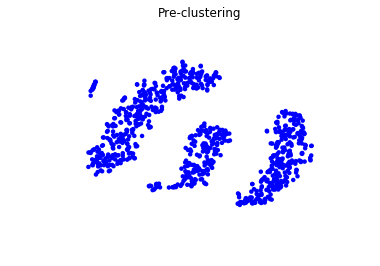

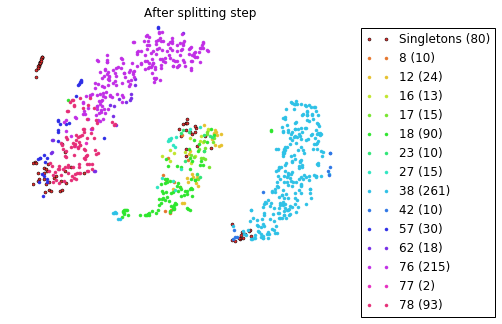

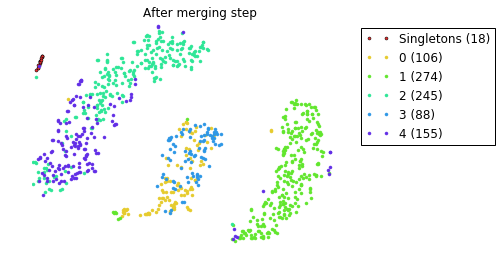

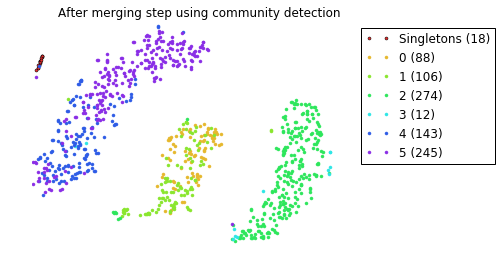

In [6]:
plt.scatter(x1,x2,edgecolors='none')
_ = plt.axis('off')
plt.title('Pre-clustering')

# Clustering results using pre-merged labels (label singletons)
plt.figure()
split.plot_labels_legend(x1,x2,split.str_labels_to_ints(ys))
plt.title('After splitting step')

# Clustering results using post-merged labels
plt.figure()
split.plot_labels_legend(x1,x2,ym)
plt.title('After merging step')

# Clustering results using post-merged labels
plt.figure()
split.plot_labels_legend(x1,x2,ym_community)
plt.title('After merging step using community detection')

## Exploring how splits were decided<a id='vissplit'></a>

We can get an idea of how the splitting step of the algorithm handled the dataset using the "print_history" function. Line i describes the ith valid split. A split is deemed valid if both clusters generated are above the min_clust_size and the lowest p-value generated from the split is below the threshold.

In [7]:
split.print_history(genes,shistory)

Pre-split: 886    L: 883    R: 3      Score: 1.8E+308  Top Gene: RPL31       Top Gene Score: 1.8E+308
Pre-split: 882    L: 484    R: 398    Score: 182.26  Top Gene: FTL         Top Gene Score: 182.26
Pre-split: 484    L: 481    R: 3      Score: 1.8E+308  Top Gene: RPL23       Top Gene Score: 1.8E+308
Pre-split: 479    L: 195    R: 284    Score: 125.49  Top Gene: IGHM        Top Gene Score: 125.49
Pre-split: 195    L: 177    R: 18     Score: 15.35  Top Gene: RRP7A       Top Gene Score: 15.35
Pre-split: 174    L: 12     R: 162    Score: 18.88  Top Gene: ANXA11      Top Gene Score: 18.88
Pre-split: 160    L: 28     R: 132    Score: 12.32  Top Gene: TTF1        Top Gene Score: 12.32
Pre-split: 28     L: 25     R: 3      Score: 13.94  Top Gene: SRPK1       Top Gene Score: 13.94
Pre-split: 132    L: 122    R: 10     Score: 18.52  Top Gene: TOP2A       Top Gene Score: 18.52
Pre-split: 122    L: 13     R: 109    Score: 24.92  Top Gene: CACYBP      Top Gene Score: 24.92
Pre-split: 109    L: 105

We can also visualize which points were involved in each split. Each row has 2 figures. Row i describes the ith split saved. In each row, the left figure indicates how the split was carried out. Blue points were not involved in the split at all. Red and green points used to be in the same cluster and are now separated. The title of the left figure indicates the split number and the 3 genes that achieved the largest t statistic (after taking an absolute value). The number associated with each gene is the -log10 of the corresponding p value. The '0' or '1' in parenthesis next to each gene indicates the cluster that had higher mean expression of that gene. The right figure shows the log expression of the gene that achieved the largest t statistic.

/Users/jessezhang/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


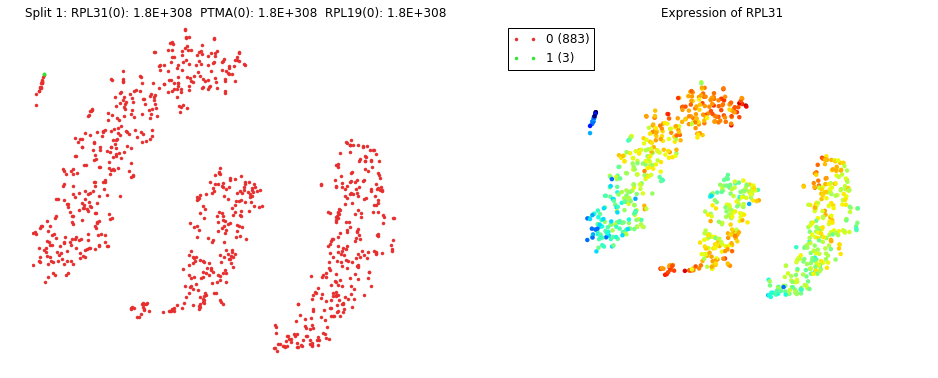

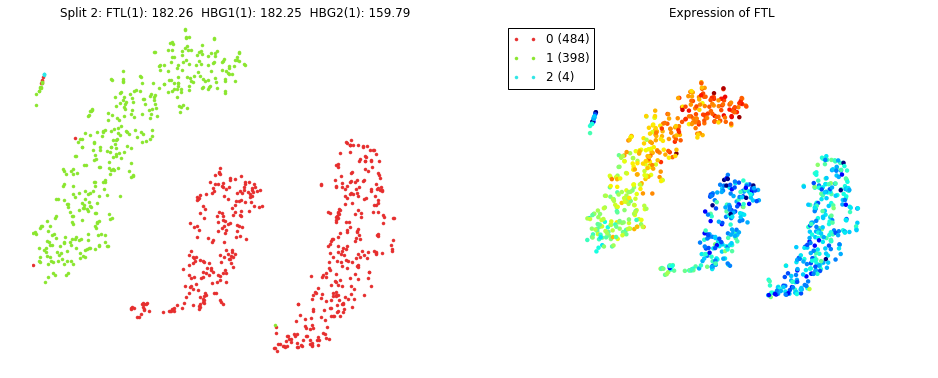

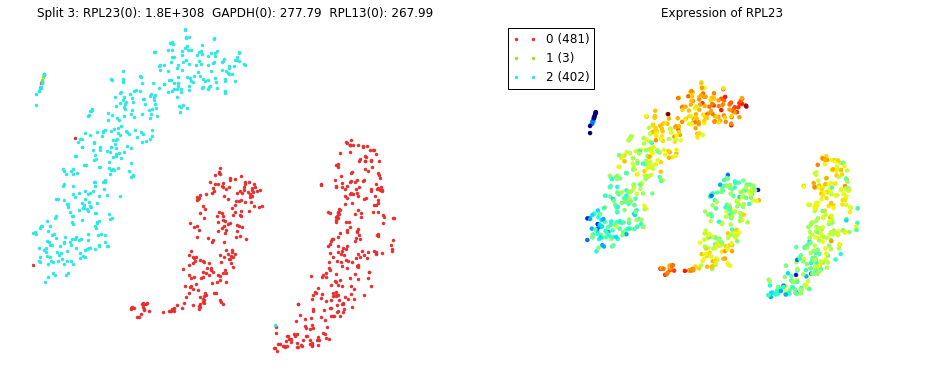

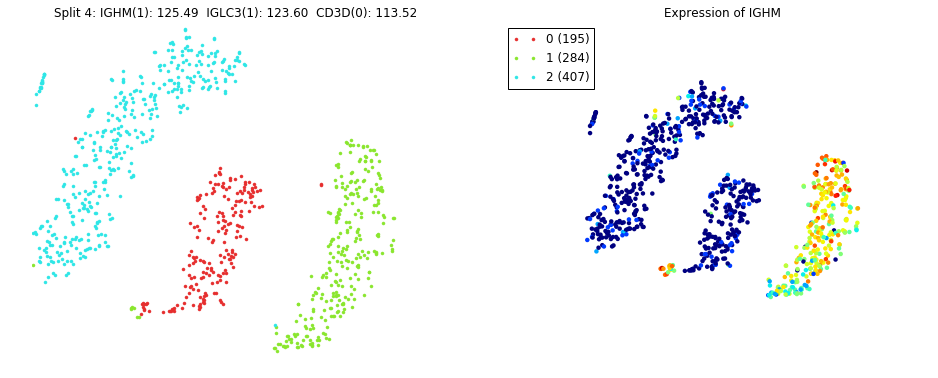

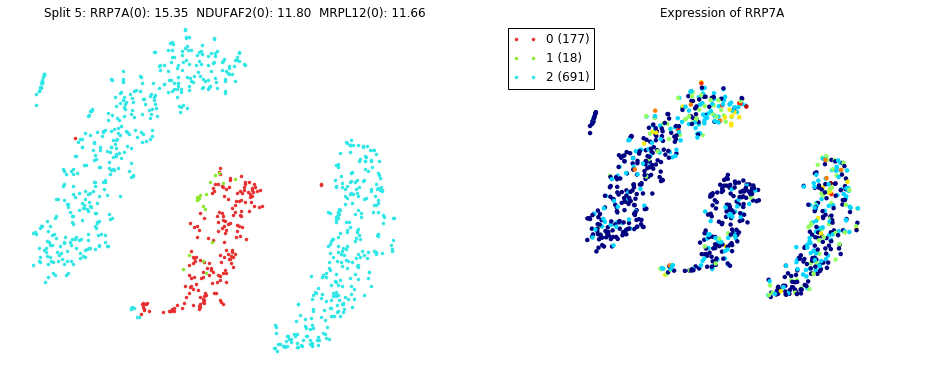

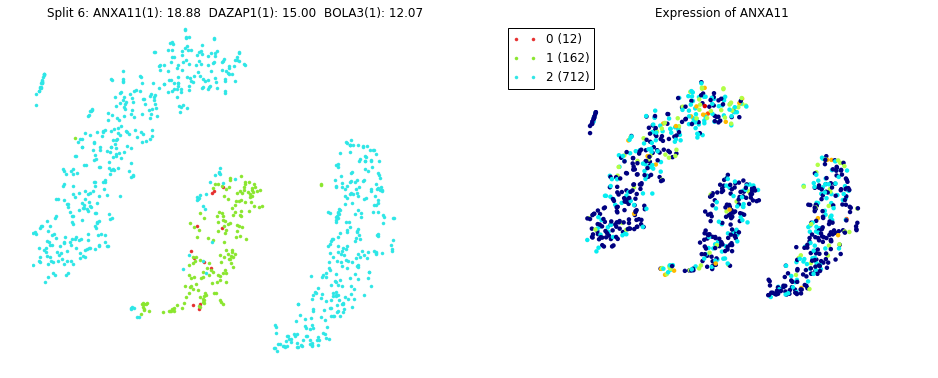

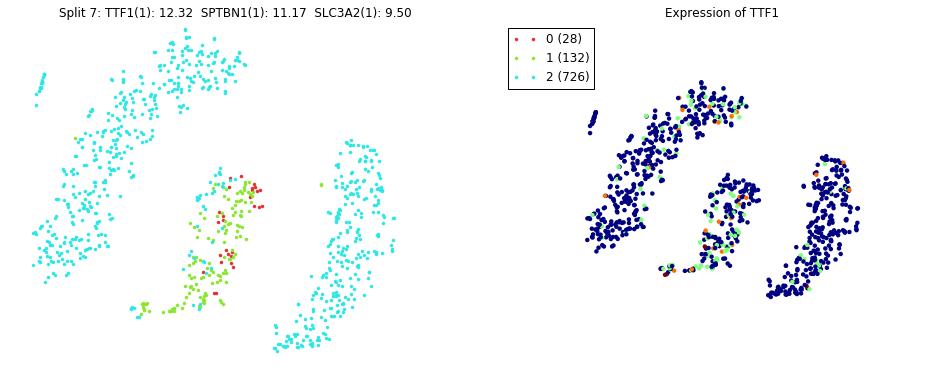

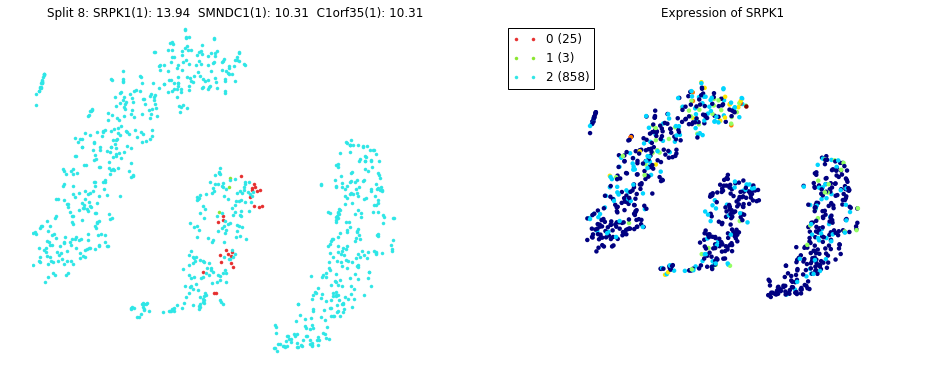

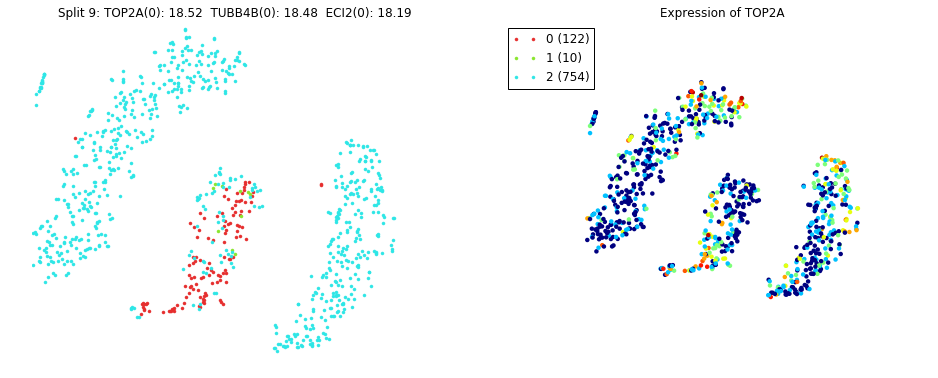

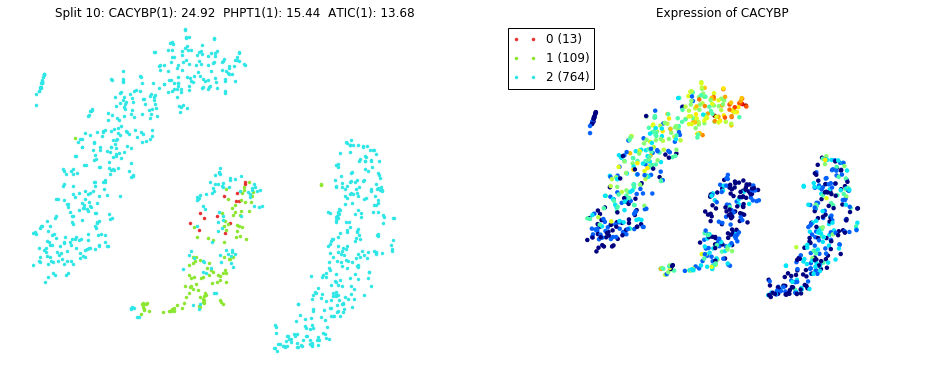

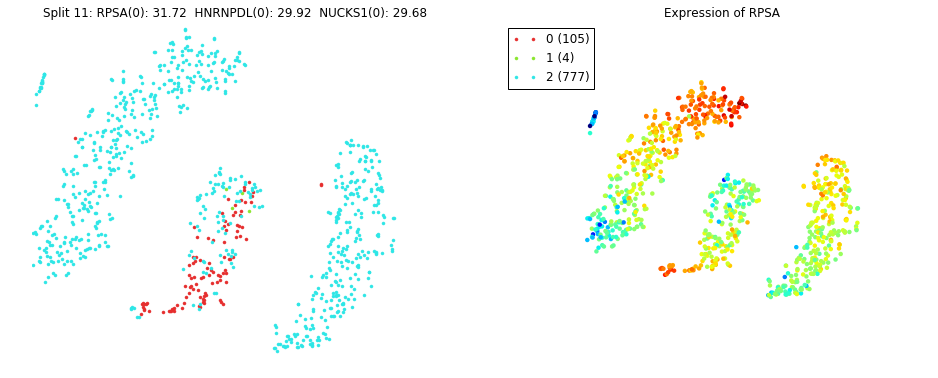

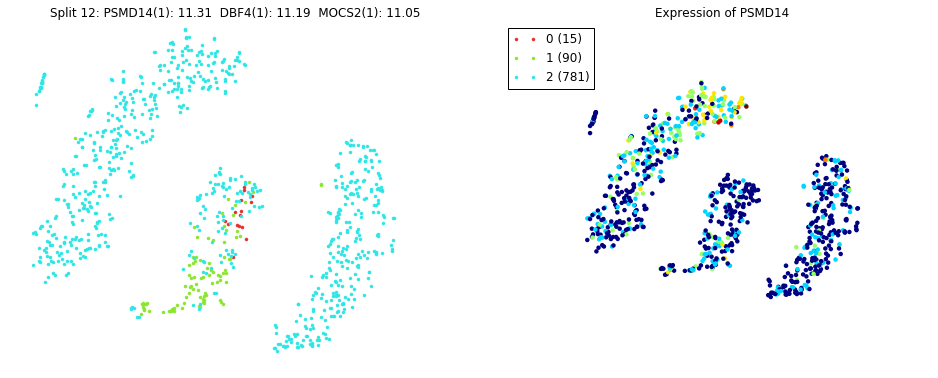

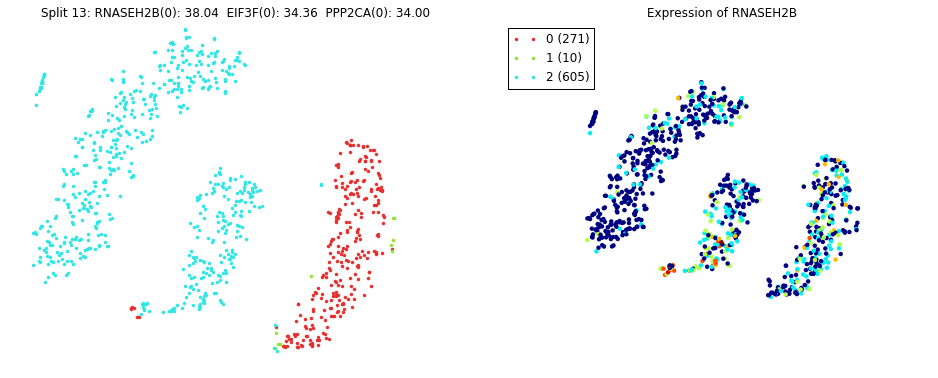

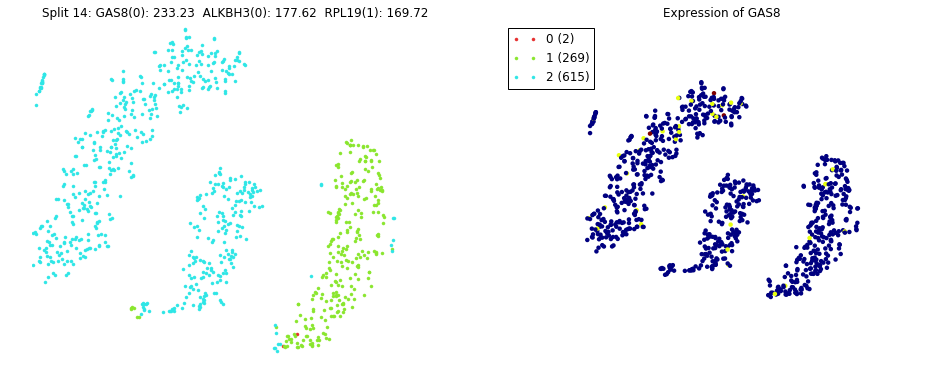

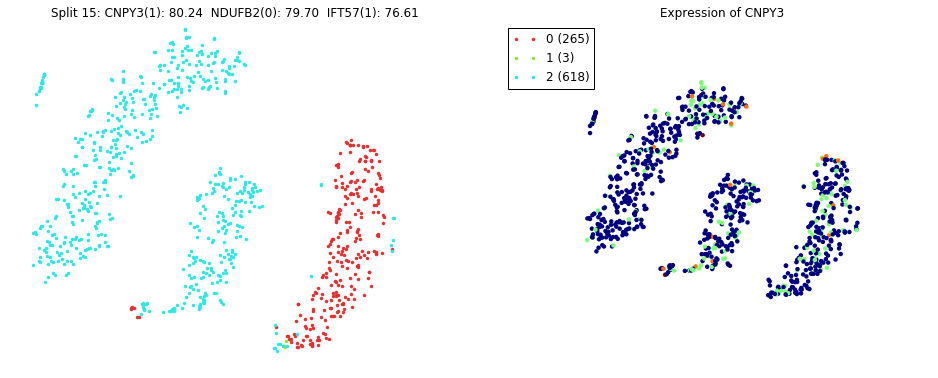

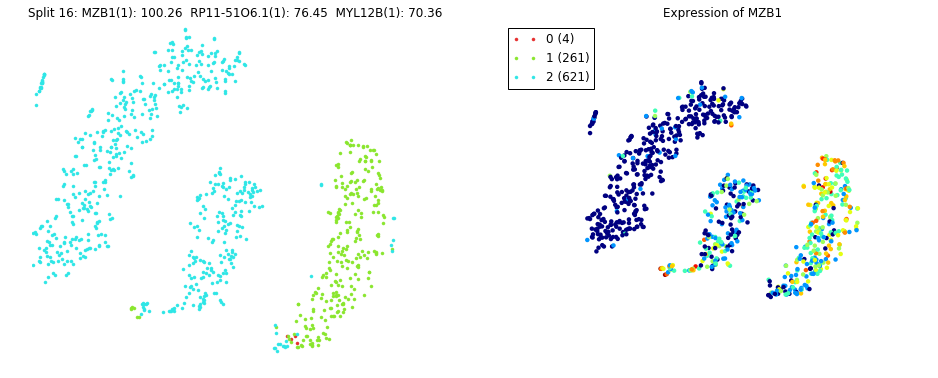

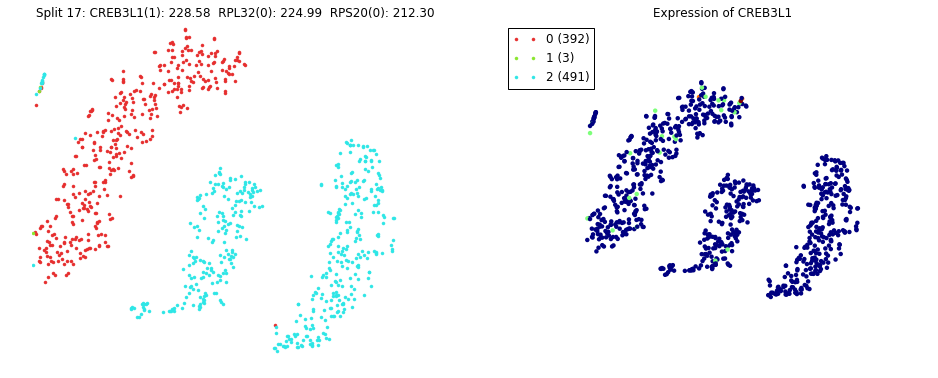

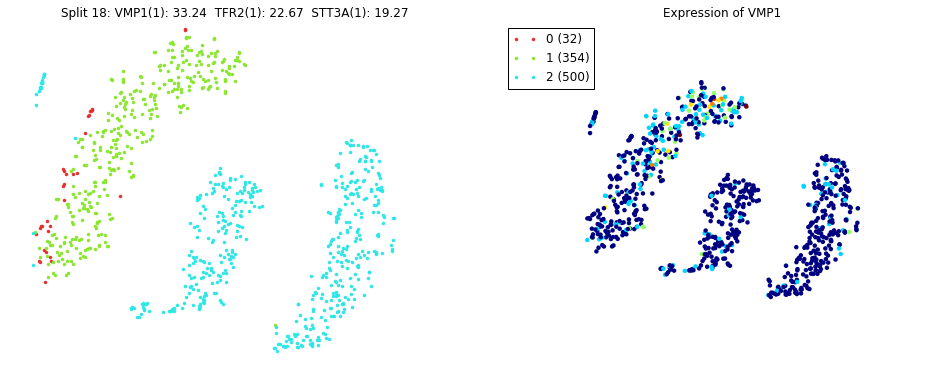

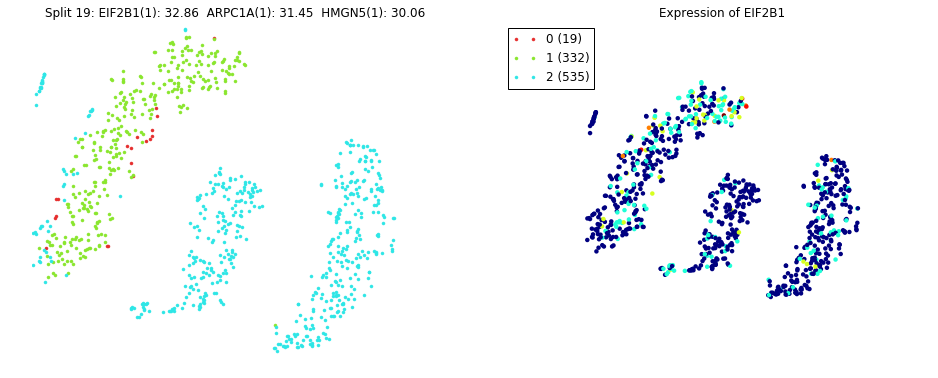

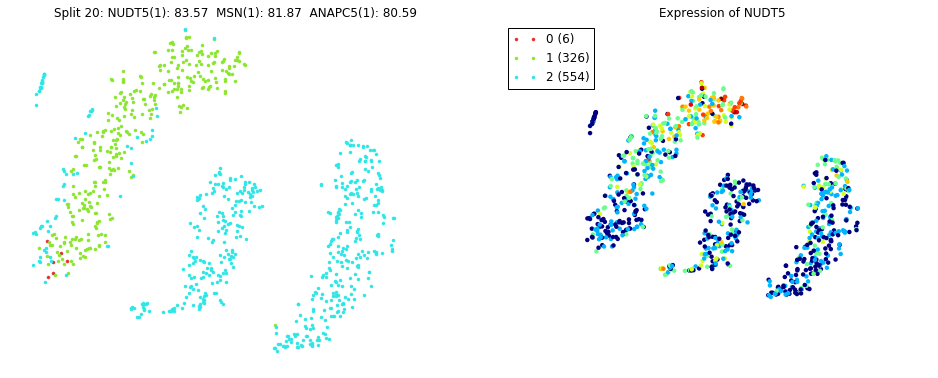

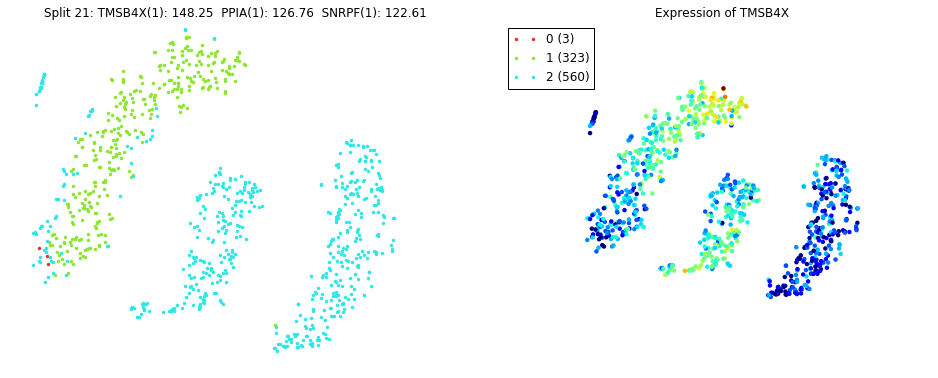

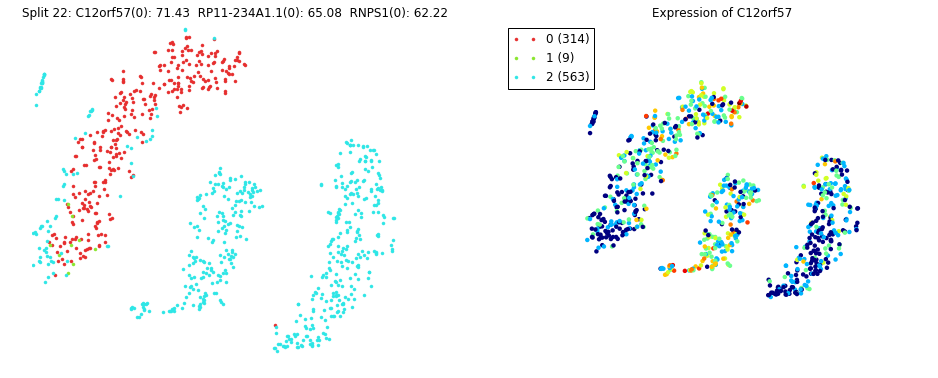

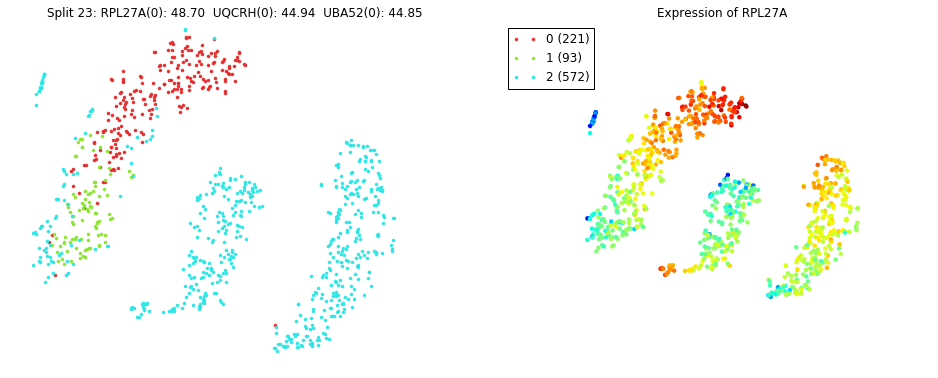

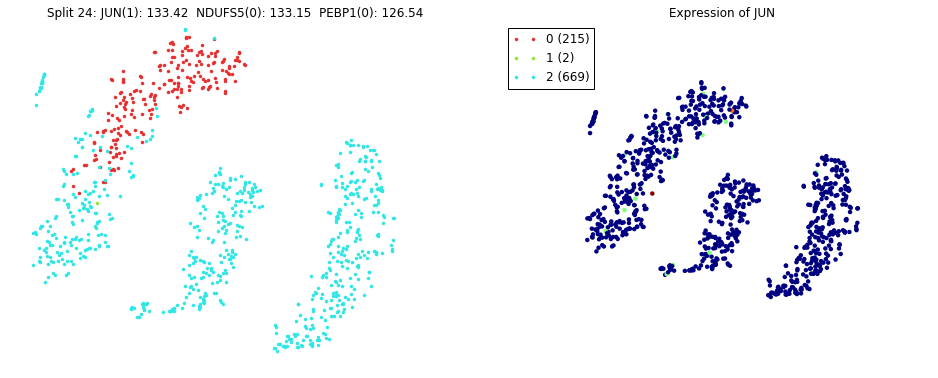

In [8]:
split.visualize_history(np.log(1+X),x1,x2,genes,shistory)

We can also use the "analyze_split" function to take a closer look at the genes that dictated why a particular split was kept. Use the "show_background" keyword to also display the cells not involved in the split. Use "clust" to only look at genes that are more highly expressed in a particular cluster. "num_genes" can be used to display a custom number of genes.

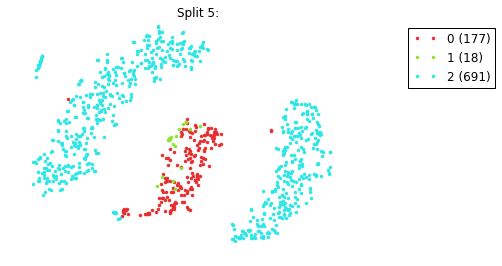

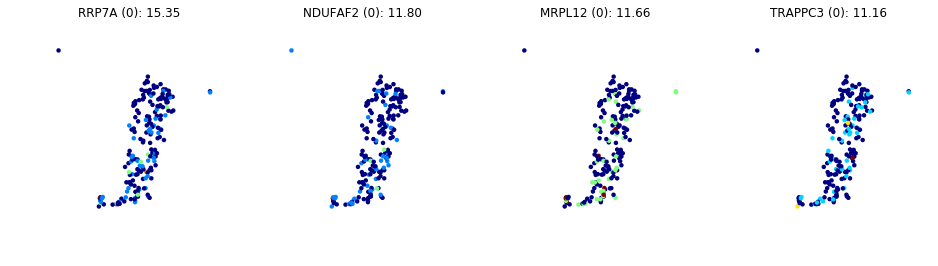

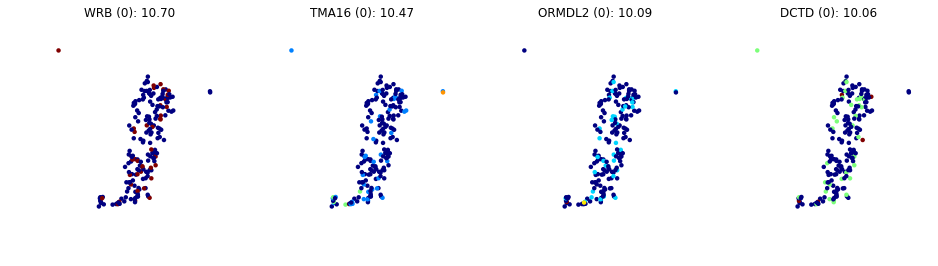

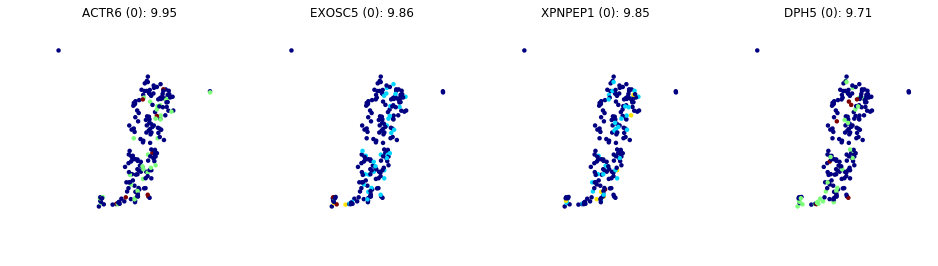

In [9]:
# Look at split 5
split_num = 5
cluster_of_interest = None
show_background = False
split.analyze_split(X,x1,x2,genes,shistory,
                    split_num,
                    num_genes=12,
                    show_background=show_background,
                    clust=cluster_of_interest)

## Exploring how merges were decided<a id='vismerge'></a>

We can also get an idea of how merging was performed using the same functions.

80 of 886 samples are singletons
Singleton(s) 442, 569, 700, 708, 717, 722, 727, 747, 791, 798, 817, 828, 840, 842, 846, 868, 876, 879 marked as outliers (N = 18)
Singleton(s) 15 merged with cluster 12 (N = 24) to form cluster 1 (N = 25)
Singleton(s) 3, 4, 6, 7, 9, 10, 11, 13, 14, 19, 20, 21, 22, 24, 25, 26 merged with cluster 18 (N = 90) to form cluster 4 (N = 106)
Singleton(s) 5, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41 merged with cluster 38 (N = 261) to form cluster 7 (N = 274)
Singleton(s) 28, 53, 55, 56, 58, 59, 60, 61, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 79, 80, 81, 82, 83, 84, 85, 86, 87, 90 merged with cluster 76 (N = 215) to form cluster 11 (N = 245)
Singleton(s) 54, 66 merged with cluster 78 (N = 93) to form cluster 13 (N = 95)
Post-merge: 25     L: 10     R: 15     Score: 3.60  Top Gene: ENOSF1      Top Gene Score: 3.60
Post-merge: 25     L: 15     R: 10     Score: 4.31  Top Gene: MAGED1      Top Gene Score: 4.31
Post-merge: 38     L: 13     R: 25     Scor

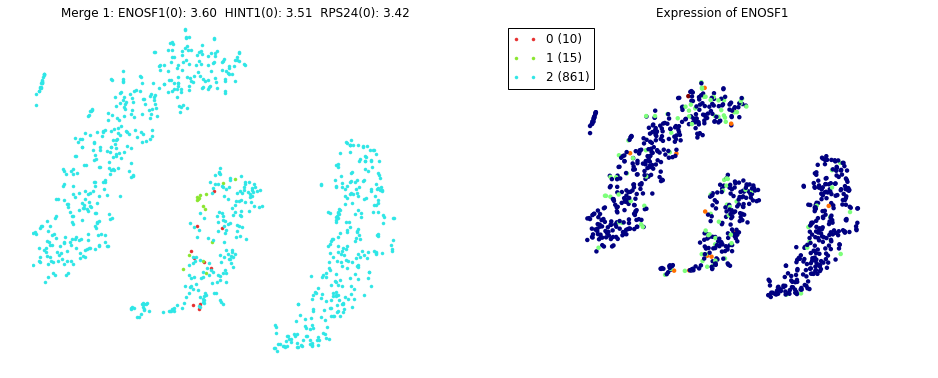

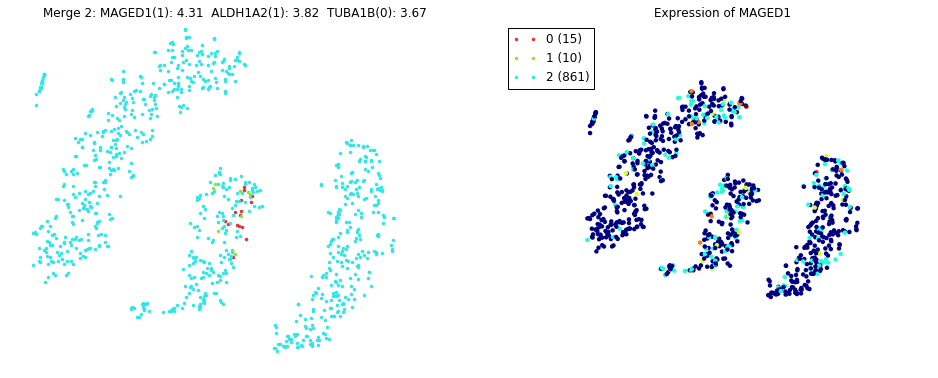

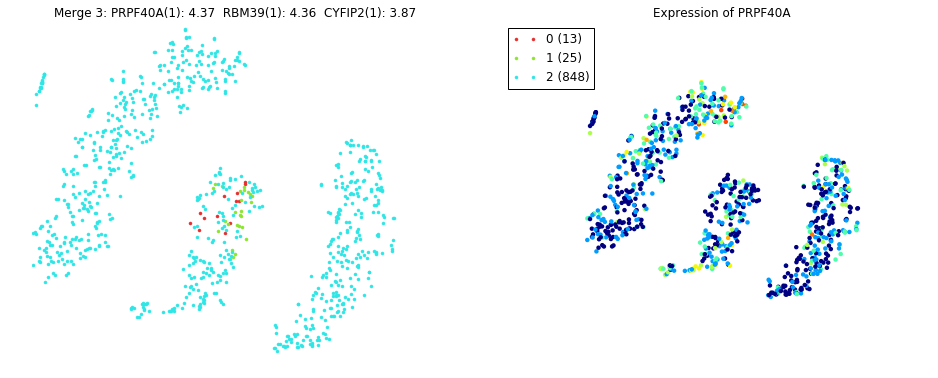

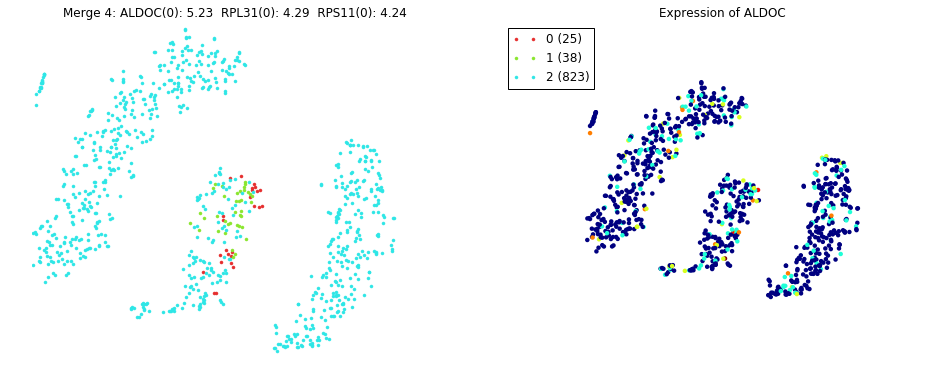

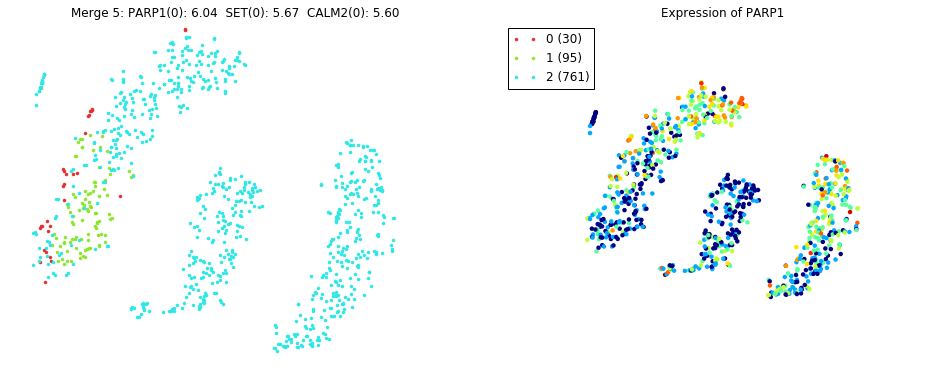

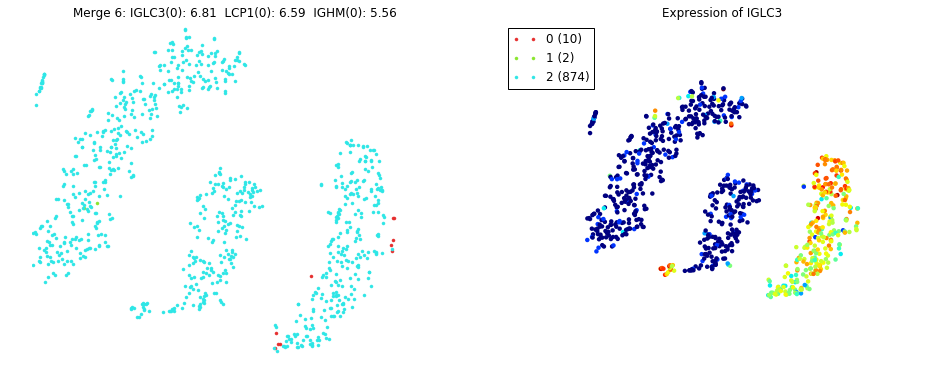

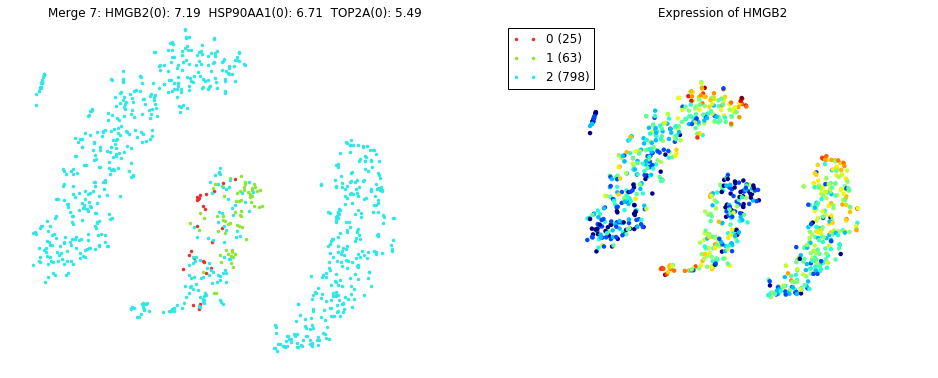

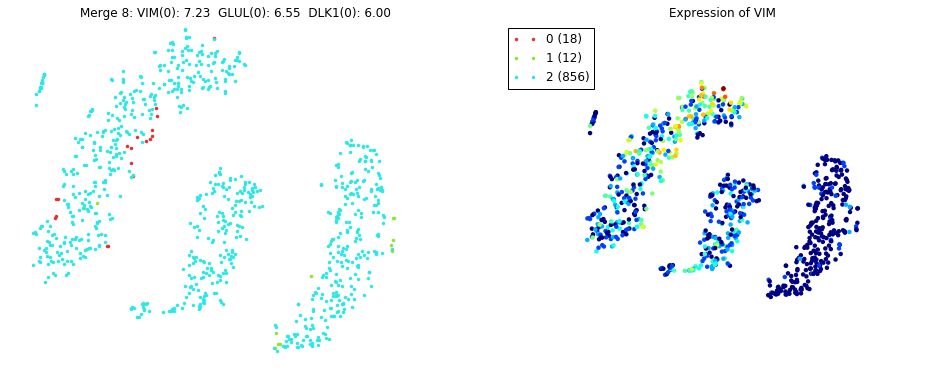

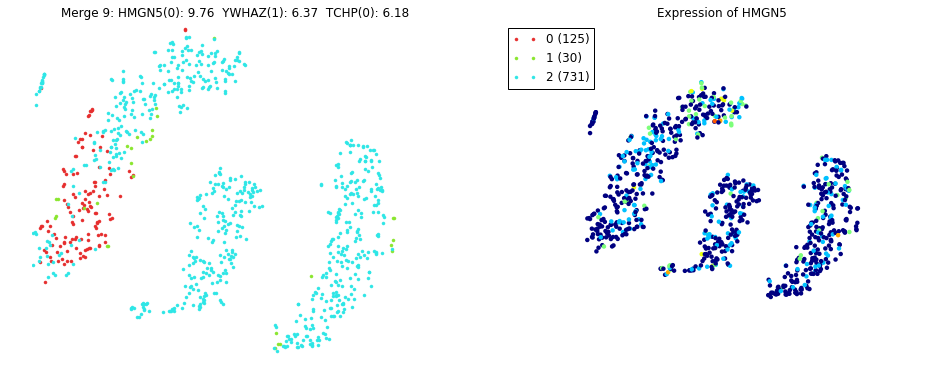

In [10]:
split.print_history(genes,mhistory)
split.visualize_history(np.log(1+X),x1,x2,genes,mhistory)

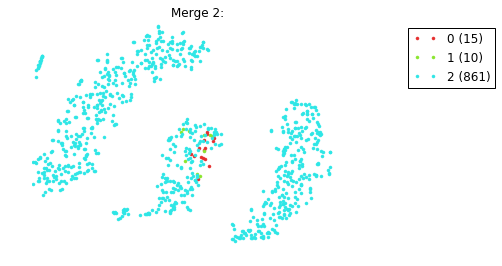

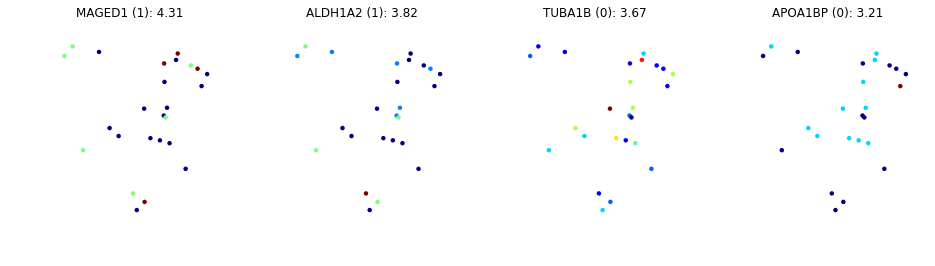

In [11]:
# Look at merge 2
merge_num = 2
cluster_of_interest = None
show_background = False
split.analyze_split(X,x1,x2,genes,mhistory,
                    merge_num,
                    num_genes=4,
                    show_background=show_background,
                    clust=cluster_of_interest)

## Differential expression<a id='diffexp'></a>

The module allows for two kinds of simple differential expression analysis. The first does a one-v-rest comparison for each cluster, visualizing the most important genes for each cluster according toa t-test for each gene. The second does a pairwise comparison for every two pairs of clusters.

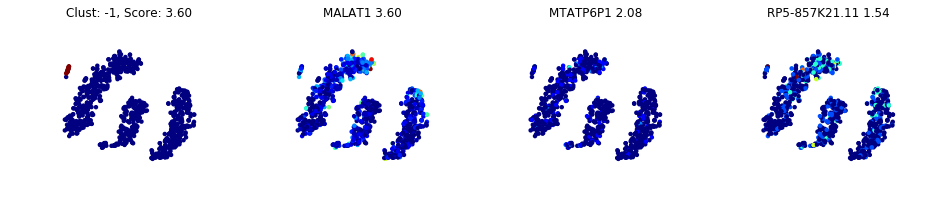

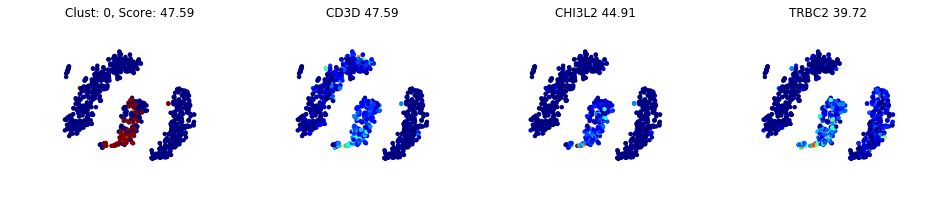

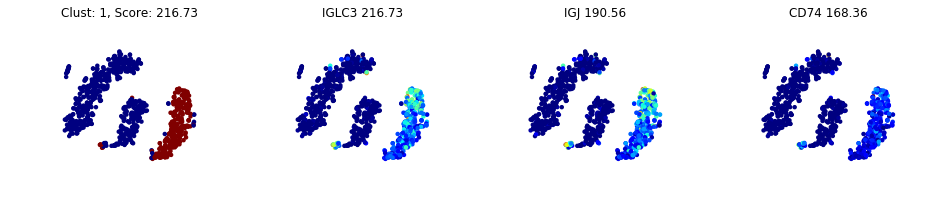

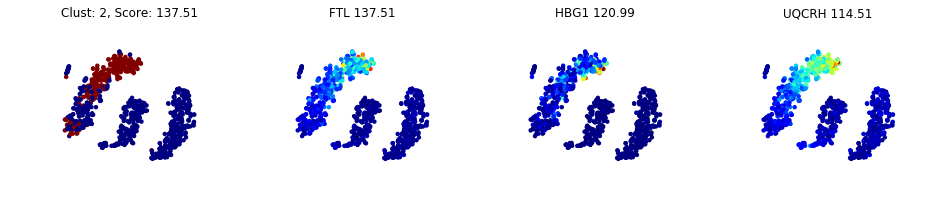

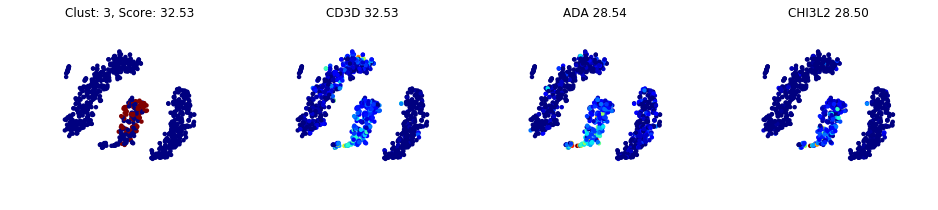

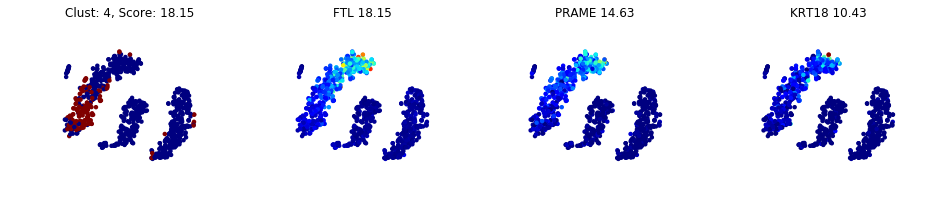

In [12]:
split.save_more_highly_expressed_genes_in_one_clust(X,genes,ym,x1,x2,num_genes=3,show_plots=True,verbose=False)

dendrosplit/utils.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  plt.plot(x1[y==i],x2[y==i],'.',c=RGBs[j],label=str(i)+' ('+str(np.sum(y==i))+')')
dendrosplit/feature_selection.py:221: RuntimeWarning: divide by zero encountered in double_scalars
  fold = g_mean_j/g_mean_i


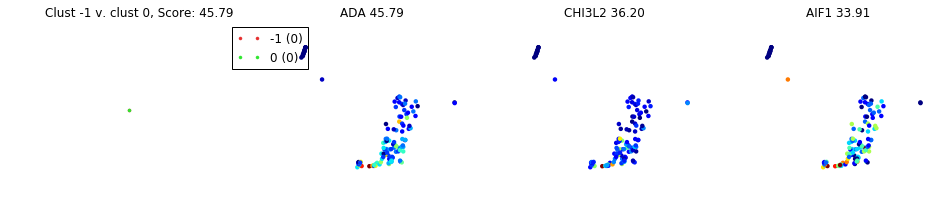

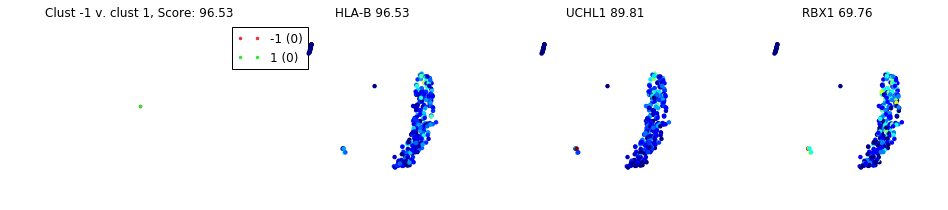

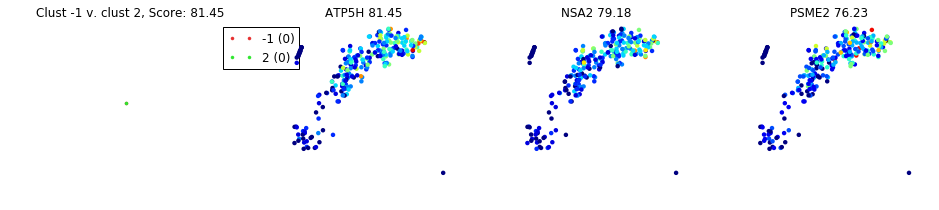

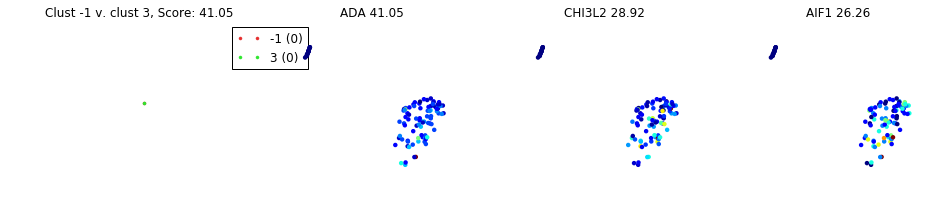

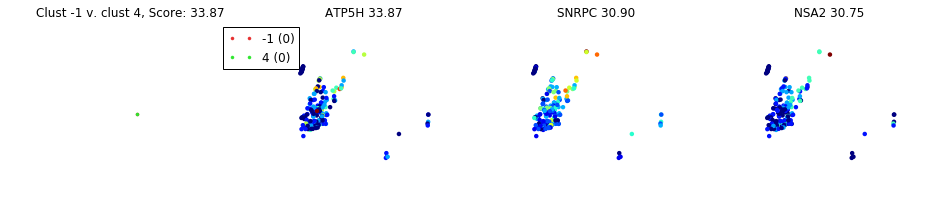

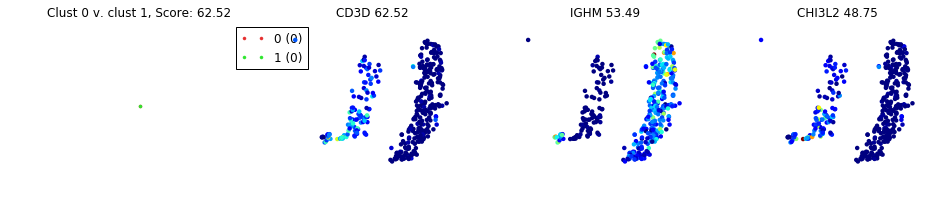

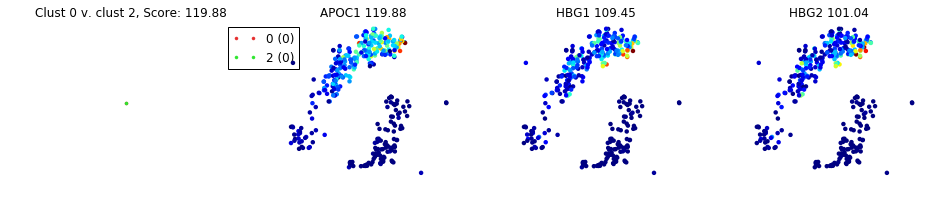

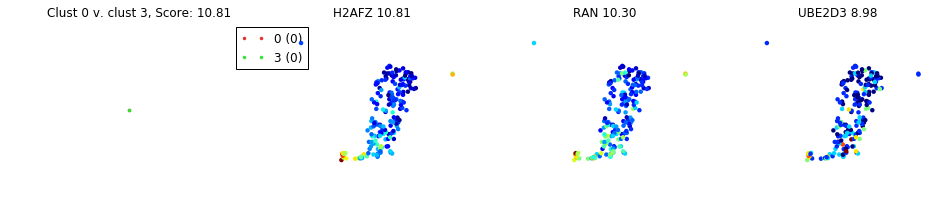

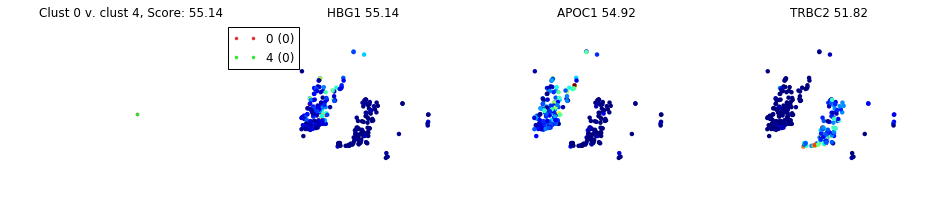

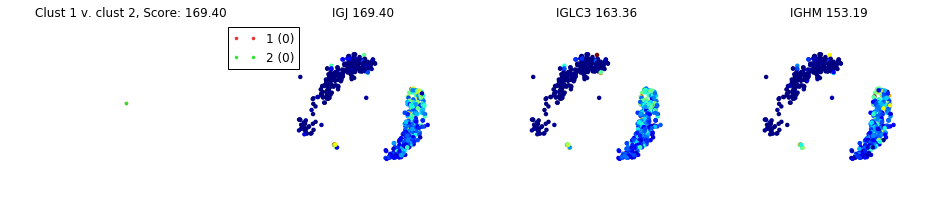

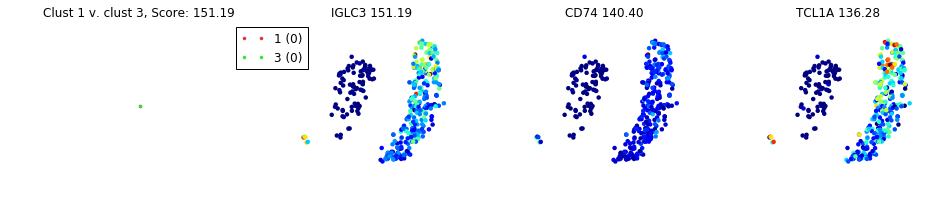

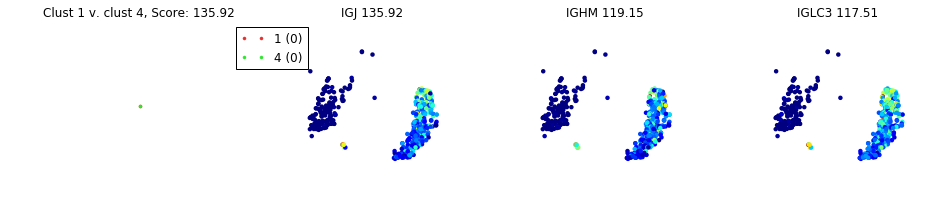

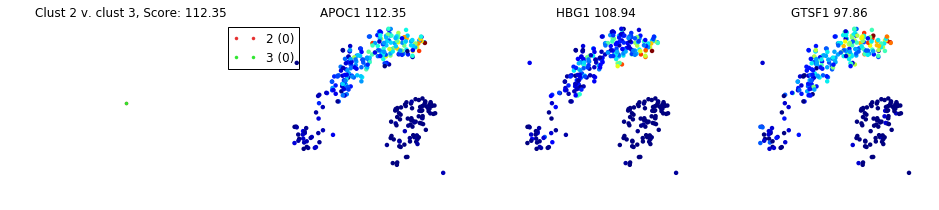

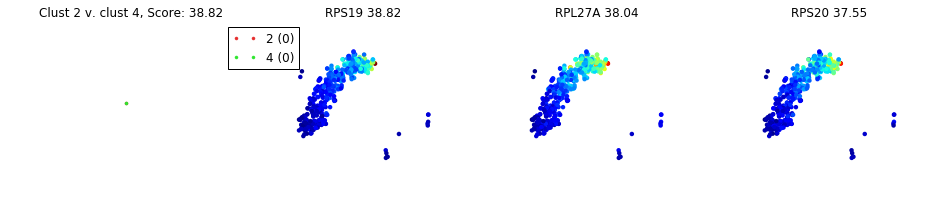

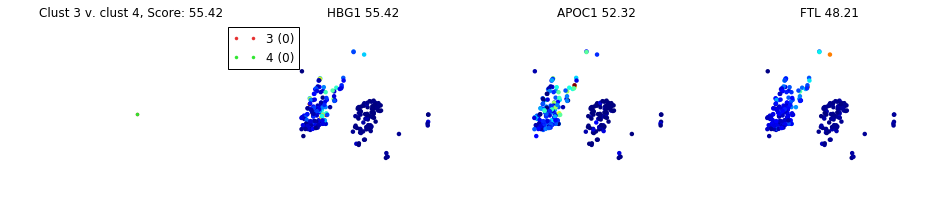

In [13]:
split.pairwise_cluster_comparison(X,genes,ym,x1=x1,x2=x2,num_genes=3,show_plots=True,verbose=False)

## Distance distribution <a id='distdist'></a>

The module also allows the user to visualize the distribution of distances within each cluster. For a given cluster, this function plots the proportion of pairwise distances (between points in the cluster) for each percentile bin of the overall set of pairwise distances (for all points in all clusters). For example, 0.3 at 1 indicates that 30% of the pairwise distances fall between the 5th and 10th percentiles of overall distances. Use this function gain a sense of how cohesize clusters are according to the original distance matrix. Intuitively, a good cluster should have points that are all close to one another. For example, a cluster with no distances in the bottom 10 bins (i.e. bottom 50 percentile) would be considered bad. Notice that as expected this is the case for cluster "-1" below, which contains the outliers.

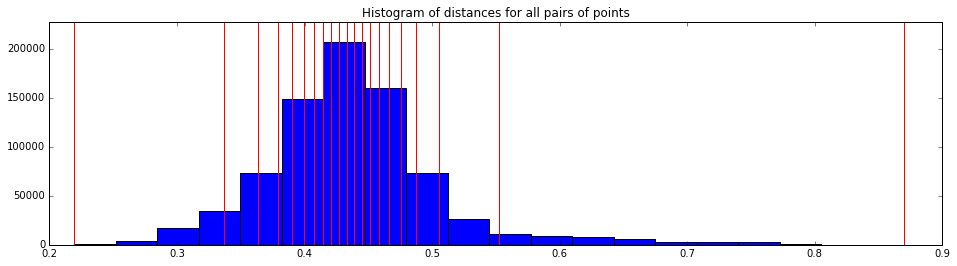

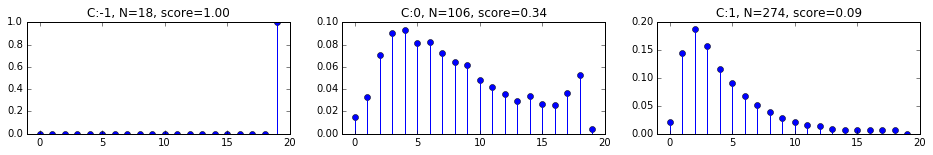

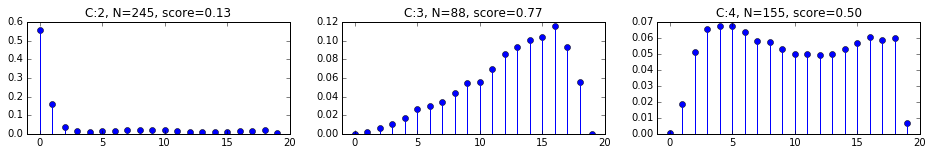

In [14]:
merge.visualize_within_cluster_distance_distributions(D,ym,show_D_dist=True)

## Dendrogram <a id='dendro'></a>

The module also allows you to generate a dendrogram and obtain the order of the cells according to the dendrogram. The dendrogram may be hard to view in an iPython notebook. We recommend saving it, as shown below. You can also feed in the cluster labels ("labels" keyword). If you do, the function will color the names of all samples within a cluster the same color.

dendrosplit/split.py:233: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if labels != None:


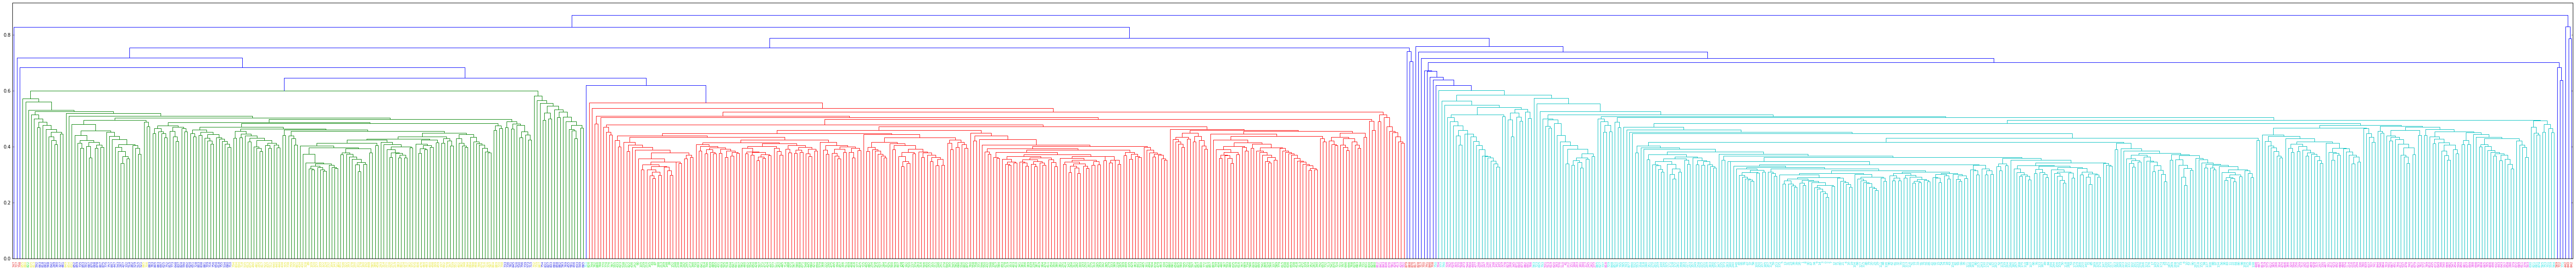

In [15]:
cell_order = split.plot_dendro(D,return_cell_order=True,labels=ym,
                               save_name='/Users/jessezhang/Desktop/dendrogram')

# Parameter Sweeping <a id='paramsweep'></a>

During the splitting step of the algorithm, we can tune two hyperparameters: score_threshold and disband_percentile. We may be curious what different clusters can be generated with different hyperparameters. We can rapidly obtain several (post-split pre-merge) clustering results by exploiting the fact that the clusters generated with a smaller score_threshold (recall that smaller threshold results in more clusters) partition the clusters generated with a larger score_threshold. 

1. Run the splitting step with a very low threshold
2. Use the ```get_clusters_from_history()``` function

An example for sweeping through various score_threshold values is done below. The same can be done with disband_percentile values.

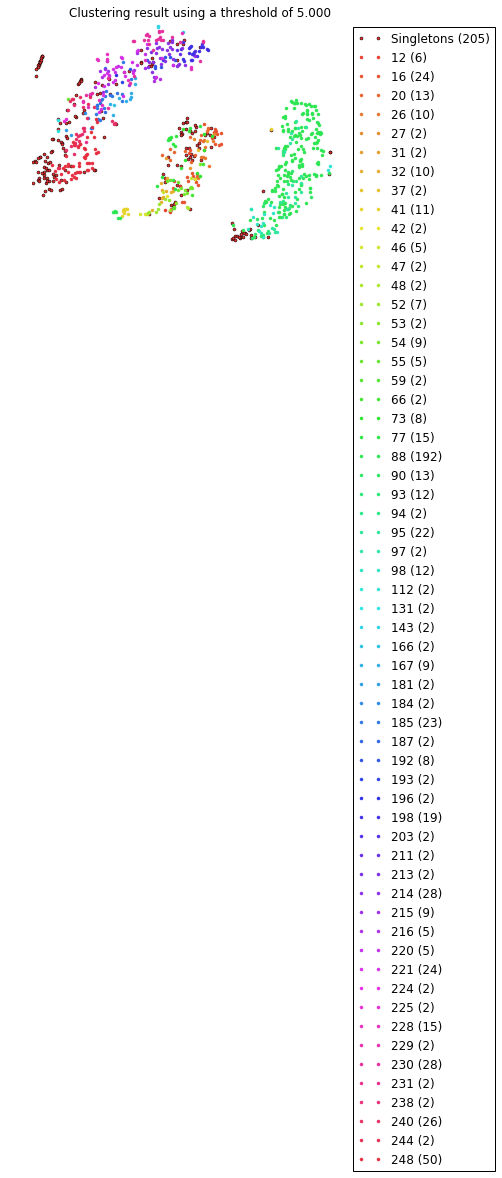

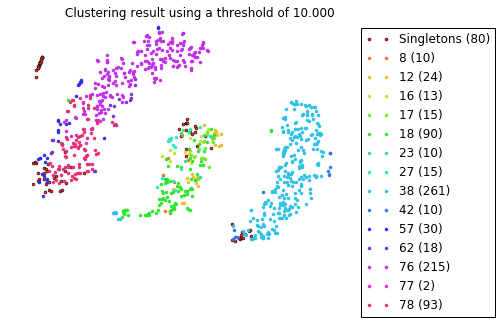

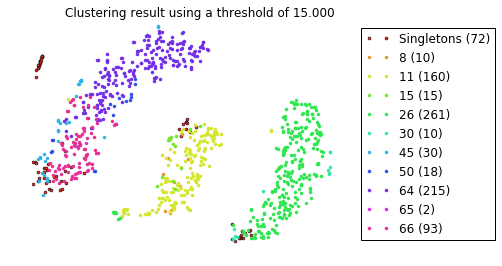

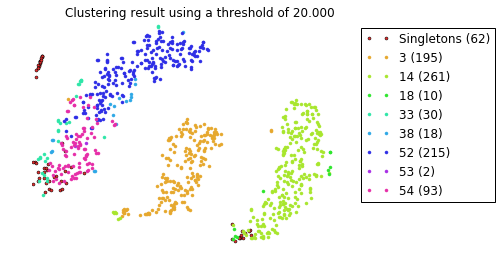

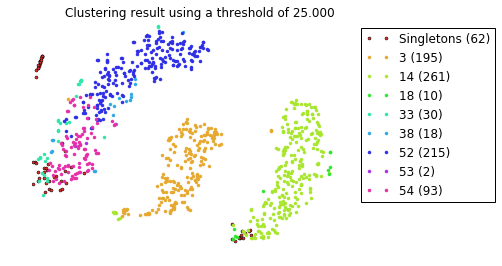

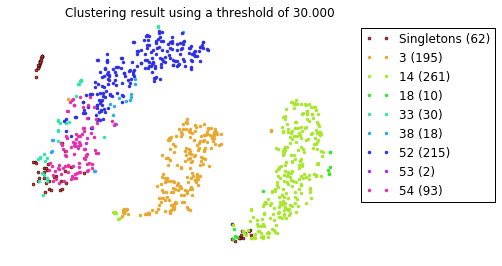

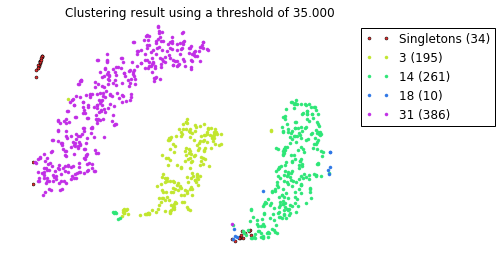

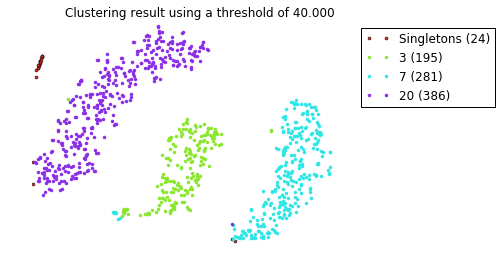

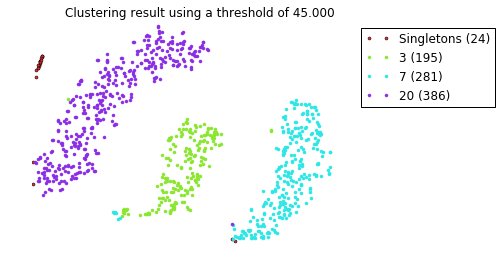

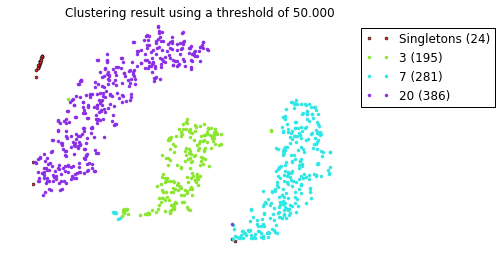

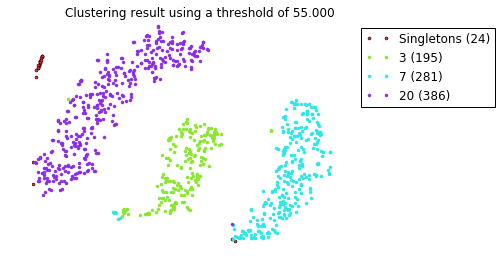

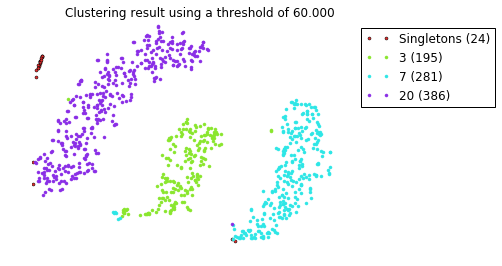

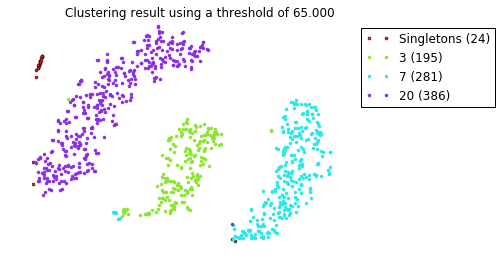

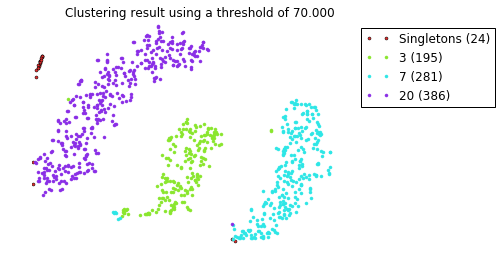

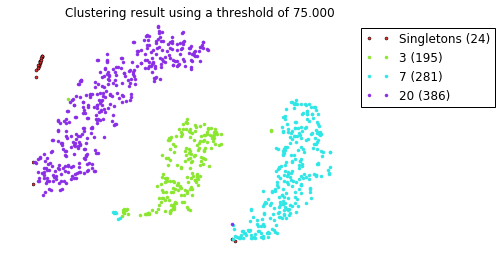

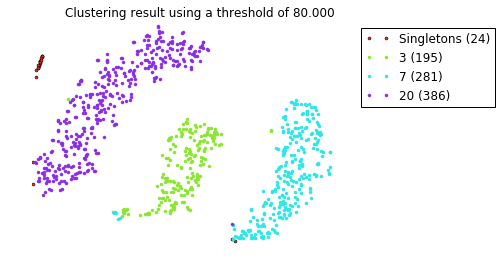

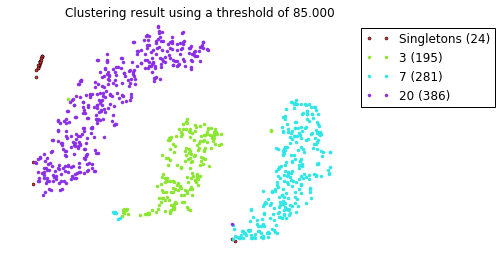

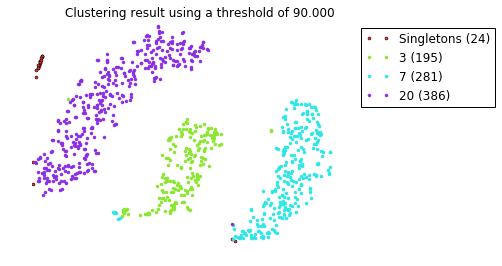

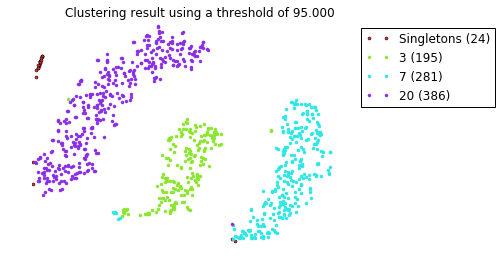

In [16]:
ys,shistory = split.dendrosplit((D,X),
                                preprocessing='precomputed',
                                score_threshold=2,
                                verbose=False,
                                disband_percentile=50)

ys_sweep = []
thresholds = range(5,100,5)
for threshold in thresholds:
    ys_sweep.append(split.get_clusters_from_history(D,shistory,threshold,50))
    plt.figure()
    split.plot_labels_legend(x1,x2,split.str_labels_to_ints(ys_sweep[-1]))
    plt.title('Clustering result using a threshold of %.3f'%(threshold))

By sweeping parameters, we can take a closer look at how the number of clusters changes as a function of the threshold. This may give us insights on how to select an optimal threshold for a particular application.

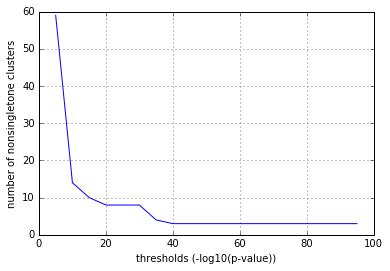

In [17]:
def count_nonsingleton_clusters(y):
    return sum([1 for i in np.unique(y) if np.sum(y==i) != 1])

plt.plot(thresholds,[count_nonsingleton_clusters(i) for i in ys_sweep])
plt.grid()
plt.xlabel('thresholds (-log10(p-value))')
plt.ylabel('number of nonsingletone clusters')